# Instalacion de requerimientos:

In [1]:
import subprocess
from getpass import getpass

password = getpass("sudo pass: ")
command = f"echo {password} | sudo -S apt install graphviz"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, error = process.communicate()

if output:
    print(output.decode("utf-8"))
if error:
    print(error.decode("utf-8"))

sudo pass:  ········


Leyendo lista de paquetes...
Creando árbol de dependencias...
Leyendo la información de estado...
graphviz ya está en su versión más reciente (2.42.2-6).
0 actualizados, 0 nuevos se instalarán, 0 para eliminar y 3 no actualizados.

[sudo] password for cesar: 




In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn 
import scipy
from scipy.stats import norm
import tensorflow as tf

from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

2023-05-09 02:06:08.636474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 02:06:08.660999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 02:06:08.661879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Ademas debe instalar esta dependencia:**

Hagalo de forma manual en una terminal.

In [3]:
print(
    "-- versiones de las librerias usadas en este estudio --\n"
    + "-" * 55 + '\n'
    f" *      Numpy : {np.__version__}\n"
    f" *     Pandas : {pd.__version__}\n"
    f" * matplotlib : {matplotlib.__version__}\n"
    f" *    sklearn : {sklearn.__version__}\n"
    f" *      scipy : {scipy.__version__}\n"
    f" * tensorflow : {tf.__version__}\n"
)

-- versiones de las librerias usadas en este estudio --
-------------------------------------------------------
 *      Numpy : 1.23.5
 *     Pandas : 2.0.1
 * matplotlib : 3.7.1
 *    sklearn : 1.2.2
 *      scipy : 1.10.1
 * tensorflow : 2.12.0



---

# Problema 0:

Merge de la data y EDA

In [4]:
# raw
data11 = pd.read_excel('Data of First_Round Experiment.xlsx', sheet_name=0)
data21 = pd.read_excel('Data of Second_Round Experiment.xlsx', sheet_name=0)

# processed
data12 = pd.read_excel('Data of First_Round Experiment.xlsx', sheet_name=1)
data22 = pd.read_excel('Data of Second_Round Experiment.xlsx', sheet_name=1)

In [5]:
print(
    f' data1 shape: {data11.shape} \n'
    f' data2 shape: {data21.shape} \n'
)

 data1 shape: (7248, 20) 
 data2 shape: (7191, 7) 



### OBS:
Lamentablemente tenemos una discordancia de data1 contra data2 en las columnas de ambos dataset (pagina 1 ambos casos).
En este caso, devemos verificar la integridad de las columnas leidas, para esto, veremos cuantos valores "Nan" contamos en cada una de las columnas,
De esta forma podremos descartar de manera responsable las columnas que (supuestamente) estan de mas.


In [6]:
def printnan(data: pd.DataFrame=pd.DataFrame()):
    '''Muestra en un print agradable
     la cuenta de filas nulas por cada
     columna en un datagrame
     
     parametros: pandas.DataFrame
     return: None
     '''
    print(f"{'col name': <12} | {'# Nan': ^5}")
    print('_'* (12 + 5 + 3))
    for col in data.columns:
        print(f'{col: <12} | {data[col].isna().sum(): ^5}')

In [7]:
printnan(data11)

col name     | # Nan
____________________
Date         |  368 
Login ID     |  368 
Action       |  368 
Page         |  368 
Next Page    |  368 
Content      | 3386 
Goal         |  368 
Unnamed: 7   | 7248 
Unnamed: 8   | 7248 
Unnamed: 9   | 7248 
Unnamed: 10  | 7248 
Unnamed: 11  | 7248 
Unnamed: 12  | 7248 
Unnamed: 13  | 7248 
Unnamed: 14  | 7248 
Unnamed: 15  | 7248 
Unnamed: 16  | 7248 
Unnamed: 17  | 7248 
Unnamed: 18  | 7248 
7249         | 7248 


Como se logra apreciar, la forma (shape) del data1, posee 7248 filas, de las cuales poseemos varias columnas que todos sus valores son "Nan"
Por ende, son descartables con total seguridad. Mirando manualmente la tabla mediante otro software (libreofice calc), se logra apreciar una celda con un numero "7249", el cual genera esta irregularidad. Pero mediante la tecnica anterior se ha podido detectar esta dificultad sin necesidad de modificar la tabla manualmente.

La solucion es quedarse con las primeras 7 columnas

In [8]:
data11 = data11[data11.columns[:7]]

print(
    f' data1 shape: {data11.shape} \n'
    f' data2 shape: {data21.shape} \n'
)

 data1 shape: (7248, 7) 
 data2 shape: (7191, 7) 



Por rigurosidad, haremos el mismo analisis al data21

In [9]:
printnan(data21)

col name     | # Nan
____________________
Time         |  260 
UserID       |  260 
Action       |  260 
Page         |  260 
NextPage     |  260 
Content      | 2588 
Goal         |  522 


Para considerar que los raw y processed sean compatibles es necesario verificar que las filas nan que se encuentran separando los grupos de sessiones en el dataset
coindicidan correctamente:

Notamos que hay un cambio de "Features" en los dataset, es decir que algunas columnas tienen nombres diferentes (pe: "Time" y "Date") cuando se refieren al mismo tipo de dato. Es necesario reparar los nombres de los "Features":

In [10]:
data21.columns

Index(['Time', 'UserID', 'Action', 'Page', 'NextPage', 'Content', 'Goal'], dtype='object')

In [11]:
data11.columns

Index(['Date', 'Login ID', 'Action', 'Page', 'Next Page', 'Content', 'Goal'], dtype='object')

In [12]:
colnames = [data11.columns[0]] + list(data21.columns[1:])
print(colnames)

['Date', 'UserID', 'Action', 'Page', 'NextPage', 'Content', 'Goal']


In [13]:
data11.columns = colnames
data21.columns = colnames

### estudiando el dataset 1.2 y 2.2 -data12 y data 22 respectivamente-

Lo que pretendemos es hacer un merge entre los raw dat y procesed data, para esto es necesario verificar que ambos dataset calzen entre sus filas NULAS. Pero antes debemos aseguranos de hacer el respectivo datacleaning

In [14]:
data12.shape

(7248, 5)

In [15]:
data12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Observation    6880 non-null   object 
 1   Time Interval  6511 non-null   object 
 2   Goal           6880 non-null   object 
 3   Unnamed: 3     0 non-null      float64
 4   Unnamed: 4     2930 non-null   float64
dtypes: float64(2), object(3)
memory usage: 283.2+ KB


Haciendo el analisis manual nos damos cuenta que las columnas terminadas en 3 y 4 son ruido, tiene  valores pero mayoritariamente estan vacias. Las descarto 

In [16]:
data12 = data12[data12.columns[:-2]]

In [17]:
data12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Observation    6880 non-null   object
 1   Time Interval  6511 non-null   object
 2   Goal           6880 non-null   object
dtypes: object(3)
memory usage: 170.0+ KB


In [18]:
data22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Observation    6931 non-null   object
 1   Time Interval  6670 non-null   object
 2   Goal           6931 non-null   object
dtypes: object(3)
memory usage: 168.7+ KB


## verificando que las filas Nan de cada dataset respectivo concidan entre si, es decir las del datra12 con el data11 y data22 con la del data21

In [19]:
nan_idx_11 = data11[data11.isnull().all(axis=1)].index

In [20]:
data12.loc[nan_idx_11].isnull().all(axis=1).sum() == len(nan_idx_11)

True

Esto verifica que todas las filas nana de "12" coninciden contra las de "11". pero esto no verifica "11" contra "12".
hacemos el proceso al reves:

In [21]:
nan_idx_12 = data12[data12.isnull().all(axis=1)].index

data11.loc[nan_idx_12].isnull().all(axis=1).sum() == len(nan_idx_12)

True

In [22]:
nan_idx_21 = data21[data21.isnull().all(axis=1)].index
nan_idx_22 = data22[data22.isnull().all(axis=1)].index

data22.loc[nan_idx_21].isnull().all(axis=1).sum() == len(nan_idx_21), data21.loc[nan_idx_22].isnull().all(axis=1).sum() == len(nan_idx_22)

(True, True)

**Se demuestra que ambos dataset coniciden en sus filas nulas, por lo que se puede hacer merge en cada caso**

In [23]:
data1 = pd.concat([data11, data12], axis=1)

In [24]:
data2 = pd.concat([data21, data22], axis=1)

Mirando ambos conjuntos de datos, notamos que hay filas nulas entre lotes de acciones tomadas por los diversos usuarios. Entonces es de interes encontrar estos grupos
de acciones para hacer un analisis por sesiones de usuarios (acciones tomadas, tiempo invertido entre clicks como tambien tiempo de sesiones)

**Para hacer el analisis propongo la idea de encontrar los indices correspondientes al primer enevento del usuario y el ultimo en cada sesion**. Para lograrlo, voy a intercalar **UNIFICAR** ambos sets de datos mediante filas nulas

In [25]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6880 non-null   datetime64[ns]
 1   UserID         6880 non-null   object        
 2   Action         6880 non-null   object        
 3   Page           6880 non-null   object        
 4   NextPage       6880 non-null   object        
 5   Content        3862 non-null   object        
 6   Goal           6880 non-null   object        
 7   Observation    6880 non-null   object        
 8   Time Interval  6511 non-null   object        
 9   Goal           6880 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 566.4+ KB


In [26]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6931 non-null   datetime64[ns]
 1   UserID         6931 non-null   object        
 2   Action         6931 non-null   object        
 3   Page           6931 non-null   object        
 4   NextPage       6931 non-null   object        
 5   Content        4603 non-null   object        
 6   Goal           6669 non-null   object        
 7   Observation    6931 non-null   object        
 8   Time Interval  6670 non-null   object        
 9   Goal           6931 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 561.9+ KB


In [27]:
ncols = len(data1.columns)
data = pd.concat([
    pd.DataFrame([[None]*ncols], columns=data1.columns),
    data1,
    pd.DataFrame([[None]*ncols], columns=data1.columns),
    data2,
    pd.DataFrame([[None]*ncols], columns=data1.columns),
],ignore_index=True)

In [28]:
data.tail(3)

Date   UserID                 Action           Page   
14439 2015-01-09 05:41:53  user083  click(Link_EditPaper)  Page_MyPapers  \
14440 2015-01-09 05:42:00  user083  click(Btn_EndSession)  Page_MyPapers   
14441                 NaT     None                   None           None   

                NextPage               Content             Goal   
14439     Page_EditPaper  [paper ID]1420802620  Not In The List  \
14440  Page_PostQuestion                   NaN  Not In The List   
14441               None                  None             None   

                          Observation Time Interval  Goal  
14439  clickEditPaperMyPapers&PaperID            5s  Test  
14440                 clickEndSession           10s  Test  
14441                            None          None  None

In [29]:
data.head(3)

Date   UserID                    Action              Page   
0                 NaT     None                      None              None  \
1 2014-09-19 06:08:30  user136           click(Btn_Skip)  Page_PreQuestion   
2 2014-09-19 06:08:52  user136  click(Menuopt_AllPapers)         Page_Home   

     NextPage Content  Goal           Observation Time Interval           Goal  
0        None    None  None                  None          None           None  
1   Page_Home     NaN  Test  clickSkipPreQuestion           NaN           Test  
2  Page_Login     NaN  Test    clickMenuAllPapers           30s  ViewAllPapers

Como se puede apreciar, he perdido el indice ***absolutamente-creciente*** en este nuevo dataframe, entonces lo recupero:

In [30]:
data = data.reset_index()[data.columns]

In [31]:
data.head(3)

Date   UserID                    Action              Page   
0                 NaT     None                      None              None  \
1 2014-09-19 06:08:30  user136           click(Btn_Skip)  Page_PreQuestion   
2 2014-09-19 06:08:52  user136  click(Menuopt_AllPapers)         Page_Home   

     NextPage Content  Goal           Goal           Observation   
0        None    None  None           None                  None  \
1   Page_Home     NaN  Test           Test  clickSkipPreQuestion   
2  Page_Login     NaN  Test  ViewAllPapers    clickMenuAllPapers   

  Time Interval  Goal           Goal  
0          None  None           None  
1           NaN  Test           Test  
2           30s  Test  ViewAllPapers

In [32]:
data.tail(3)

Date   UserID                 Action           Page   
14439 2015-01-09 05:41:53  user083  click(Link_EditPaper)  Page_MyPapers  \
14440 2015-01-09 05:42:00  user083  click(Btn_EndSession)  Page_MyPapers   
14441                 NaT     None                   None           None   

                NextPage               Content             Goal  Goal   
14439     Page_EditPaper  [paper ID]1420802620  Not In The List  Test  \
14440  Page_PostQuestion                   NaN  Not In The List  Test   
14441               None                  None             None  None   

                          Observation Time Interval             Goal  Goal  
14439  clickEditPaperMyPapers&PaperID            5s  Not In The List  Test  
14440                 clickEndSession           10s  Not In The List  Test  
14441                            None          None             None  None

Esto me da la posibilidad de analizar ahora por indices (**Esto es mucho mas eficiente que analizar fila por fila**)

NOTA: **Recordar que para que cada indece se corresponda con el inicio y el final, debemos sumar y restar uno a cada borde (superior e inferior) de cada grupo**

In [33]:
idx = (
    data
    [data['Date'].isna()]
    .index
    .to_list()
)
groups_id = [[idx[i], idx[i + 1]] for i in range(len(idx) - 1)]

PROBEMOS:

In [34]:
data.loc[groups_id[0]]

Date UserID Action  Page NextPage Content  Goal  Goal Observation   
0   NaT   None   None  None     None    None  None  None        None  \
10  NaT    NaN    NaN   NaN      NaN     NaN   NaN   NaN         NaN   

   Time Interval  Goal  Goal  
0           None  None  None  
10           NaN   NaN   NaN

Encambio con los limites corregidos

In [35]:
groups_id = [[idx[i] + 1, idx[i + 1] -1] for i in range(len(idx) - 1)]

data.loc[groups_id[0]]

Date   UserID                 Action              Page   
1 2014-09-19 06:08:30  user136        click(Btn_Skip)  Page_PreQuestion  \
9 2014-09-19 06:15:42  user136  click(Btn_EndSession)    Page_AllPapers   

            NextPage Content  Goal  Goal           Observation Time Interval   
1          Page_Home     NaN  Test  Test  clickSkipPreQuestion           NaN  \
9  Page_PostQuestion     NaN  Test  Test       clickEndSession             m   

   Goal  Goal  
1  Test  Test  
9  Test  Test

Comparando con el dataframe

In [36]:
data.head(12)

Date   UserID                    Action              Page   
0                  NaT     None                      None              None  \
1  2014-09-19 06:08:30  user136           click(Btn_Skip)  Page_PreQuestion   
2  2014-09-19 06:08:52  user136  click(Menuopt_AllPapers)         Page_Home   
3  2014-09-19 06:09:19  user136          click(Btn_Login)        Page_Login   
4  2014-09-19 06:09:34  user136  click(Menuopt_AllPapers)         Page_Home   
5  2014-09-19 06:11:21  user136    click(Link_PaperInfos)    Page_AllPapers   
6  2014-09-19 06:12:25  user136    click(Link_PaperInfos)    Page_AllPapers   
7  2014-09-19 06:12:56  user136    click(Link_PaperInfos)    Page_AllPapers   
8  2014-09-19 06:13:04  user136      click(Link_Download)    Page_AllPapers   
9  2014-09-19 06:15:42  user136     click(Btn_EndSession)    Page_AllPapers   
10                 NaT      NaN                       NaN               NaN   
11 2014-10-01 05:27:19  user136           click(Btn_Skip)  Page_PreQuestion   

             NextPage                                            Content   
0                None                                               None  \
1           Page_Home                                                NaN   
2          Page_Login                                                NaN   
3           Page_Home  [Login ID]KatsunoriOyama [Password]271adc [Mes...   
4      Page_AllPapers                                                NaN   
5      Page_AllPapers                               [paper ID]1408576997   
6      Page_AllPapers                               [paper ID]1411080709   
7      Page_AllPapers                               [paper ID]1410992783   
8      Page_AllPapers                               [paper ID]1411080709   
9   Page_PostQuestion                                                NaN   
10                NaN                                                NaN   
11          Page_Home                                                NaN   

    Goal            Goal              Observation Time Interval  Goal   
0   None            None                     None          None  None  \
1   Test            Test     clickSkipPreQuestion           NaN  Test   
2   Test   ViewAllPapers       clickMenuAllPapers           30s  Test   
3   Test   ViewAllPapers     clickLogin&LoginGood           30s  Test   
4   Test   ViewAllPapers       clickMenuAllPapers           20s  Test   
5   Test  ViewAPaperInfo  clickPaperInfos&PaperID             m  Test   
6   Test  ViewAPaperInfo  clickPaperInfos&PaperID             m  Test   
7   Test  ViewAPaperInfo  clickPaperInfos&PaperID           60s  Test   
8   Test   DownloadPaper    clickDownload&PaperID           10s  Test   
9   Test            Test          clickEndSession             m  Test   
10   NaN             NaN                      NaN           NaN   NaN   
11  Test            Test     clickSkipPreQuestion           NaN  Test   

              Goal  
0             None  
1             Test  
2    ViewAllPapers  
3    ViewAllPapers  
4    ViewAllPapers  
5   ViewAPaperInfo  
6   ViewAPaperInfo  
7   ViewAPaperInfo  
8    DownloadPaper  
9             Test  
10             NaN  
11            Test

**notamos que ahora la salida es correcta**

# Problema 1:

**Construccion de un dataset robusto**  que permita el entrenamiento y estudio de los datos con diversos analisis estadisiticos como IA

In [37]:
def buildds(data: pd.DataFrame = pd.DataFrame()):
    raw = defaultdict(list)

    posible_clicks = list(data['Action'].dropna().unique())
    posible_pages = list(data['Page'].dropna().unique())

    sessions_idx_ = data[data.isna().all(axis=1)].index.to_numpy()
    sessions_idx = [(sessions_idx_[i] + 1, sessions_idx_[i + 1] - 1) for i in range(len(sessions_idx_) - 1)]

    
    for i, j in sessions_idx:
        df = data.loc[i:j]
    
        # == userid ==
        # descartamos las sessiones que ya no se encuentran presentes
        # (recuerde que las descartamos anteriormente segun su STD)
        # lo que con el parametro "loc" obtendremos aveces SESSIONES VACIAS
        if len(df['UserID'].unique()) == 0:
            print(df['UserID'].unique())
            continue
        raw['user-id'].append(df['UserID'].unique()[-1])
    
        # == session duration ==
        raw['session-duration'].append(
            df.sort_values('Date')
            ['Date'].diff().dt.total_seconds().sum()
        )

        # == hour of conection ==
        loggin = df[df['Action'] == 'click(Btn_Login)']
        trys = loggin.shape[0]
        
        if trys > 1:
            # multiples intentos de loggin
                dt = loggin['Date'].to_list()[-1].hour
        
        elif trys == 0:
            # no hay intentos de loggin
            dt = None
        
        else:
            dt = pd.Timestamp(loggin['Date'].values[0]).hour
        raw['loggin-hour'].append(dt)
        
        # == trys to conect ==
        raw['try-conect'].append(trys)

        # == clicks ==
        actions = df['Action'].to_list()
        for pc in posible_clicks:
            raw[pc] = actions.count(pc)
    
        # == pages ==
        pages = df['Page'].to_list()
        for pg in posible_pages:
            raw[pg] = actions.count(pg)

    return pd.DataFrame(raw)

In [38]:
%%time
ds = buildds(data)

ds

CPU times: user 670 ms, sys: 3.73 ms, total: 673 ms
Wall time: 673 ms


user-id  session-duration  loggin-hour  try-conect  click(Btn_Skip)   
0    user136             432.0          6.0           1                0  \
1    user136             347.0          5.0           1                0   
2    user136             210.0         21.0           1                0   
3    user015             113.0          1.0           1                0   
4    user015             986.0         13.0           1                0   
..       ...               ...          ...         ...              ...   
625  user196             140.0          0.0           1                0   
626  user186             622.0         21.0           1                0   
627  user188             125.0         20.0           2                0   
628  user017            1881.0          0.0           1                0   
629  user083             175.0          5.0           1                0   

     click(Menuopt_AllPapers)  click(Btn_Login)  click(Link_PaperInfos)   
0                           1                 1                       0  \
1                           1                 1                       0   
2                           1                 1                       0   
3                           1                 1                       0   
4                           1                 1                       0   
..                        ...               ...                     ...   
625                         1                 1                       0   
626                         1                 1                       0   
627                         1                 1                       0   
628                         1                 1                       0   
629                         1                 1                       0   

     click(Link_Download)  click(Btn_EndSession)  ...  Page_MyProfile   
0                       0                      1  ...               0  \
1                       0                      1  ...               0   
2                       0                      1  ...               0   
3                       0                      1  ...               0   
4                       0                      1  ...               0   
..                    ...                    ...  ...             ...   
625                     0                      1  ...               0   
626                     0                      1  ...               0   
627                     0                      1  ...               0   
628                     0                      1  ...               0   
629                     0                      1  ...               0   

     Page_ListUsers  Page_UploadPaper  Page_SubmitComment  Page_ConfigSystem   
0                 0                 0                   0                  0  \
1                 0                 0                   0                  0   
2                 0                 0                   0                  0   
3                 0                 0                   0                  0   
4                 0                 0                   0                  0   
..              ...               ...                 ...                ...   
625               0                 0                   0                  0   
626               0                 0                   0                  0   
627               0                 0                   0                  0   
628               0                 0                   0                  0   
629               0                 0                   0                  0   

     Page_EditPaper  Page_EditComment  Page_ConfirmRemoveComment   
0                 0                 0                          0  \
1                 0                 0                          0   
2                 0                 0                          0   
3                 0                 0                          0   
4            

---
*Hemos construido una funcion que de una manera eficiente construye un dataset apto para hacer un estudio estadisitico de una manera mas facil, habilitando la posibilidad de estudiar el problema con modelos estadisiticos de ml (machine learning) ademas de poder analizar las sessiones comparandolas entre ellas*

---

# Existen sessiones "Fantasmas", es decir, sin haber loggins ?

Se considera, que las sessiones sin logins deben ser descartadas por que no podrian ser consideradas sessiones reales (**Tambien podrian ser consideradas sessiones anoamlas**):

In [39]:
na_sessions = ds['loggin-hour'].isna().sum() 
print(f'contamos con {na_sessions} sessiones sin loggeo')

contamos con 28 sessiones sin loggeo


Para el analisis de la hora de loggeo, es necesario descartar estas sessiones anomalas las cuales no cuentan con hora de loggin:

In [40]:

loggins_mean_std = (
    ds
    [ds['loggin-hour'].notna()]
    .groupby('user-id')
    ['loggin-hour'].agg([np.mean, np.std])
)
loggins_mean_std

mean        std
user-id                      
user012  10.333333   7.763161
user015  10.428571   9.015859
user017  12.750000   8.956243
user018   8.428571   9.846440
user020  11.666667   8.386497
...            ...        ...
user249   4.250000   7.182154
user252   7.800000  10.084642
user255   1.200000   0.836660
user258  11.250000  11.383468
user260  13.833333   9.261029

[98 rows x 2 columns]

**Graficamos el comportamiento promedio de los usuarios para hacer una inspeccion simple**

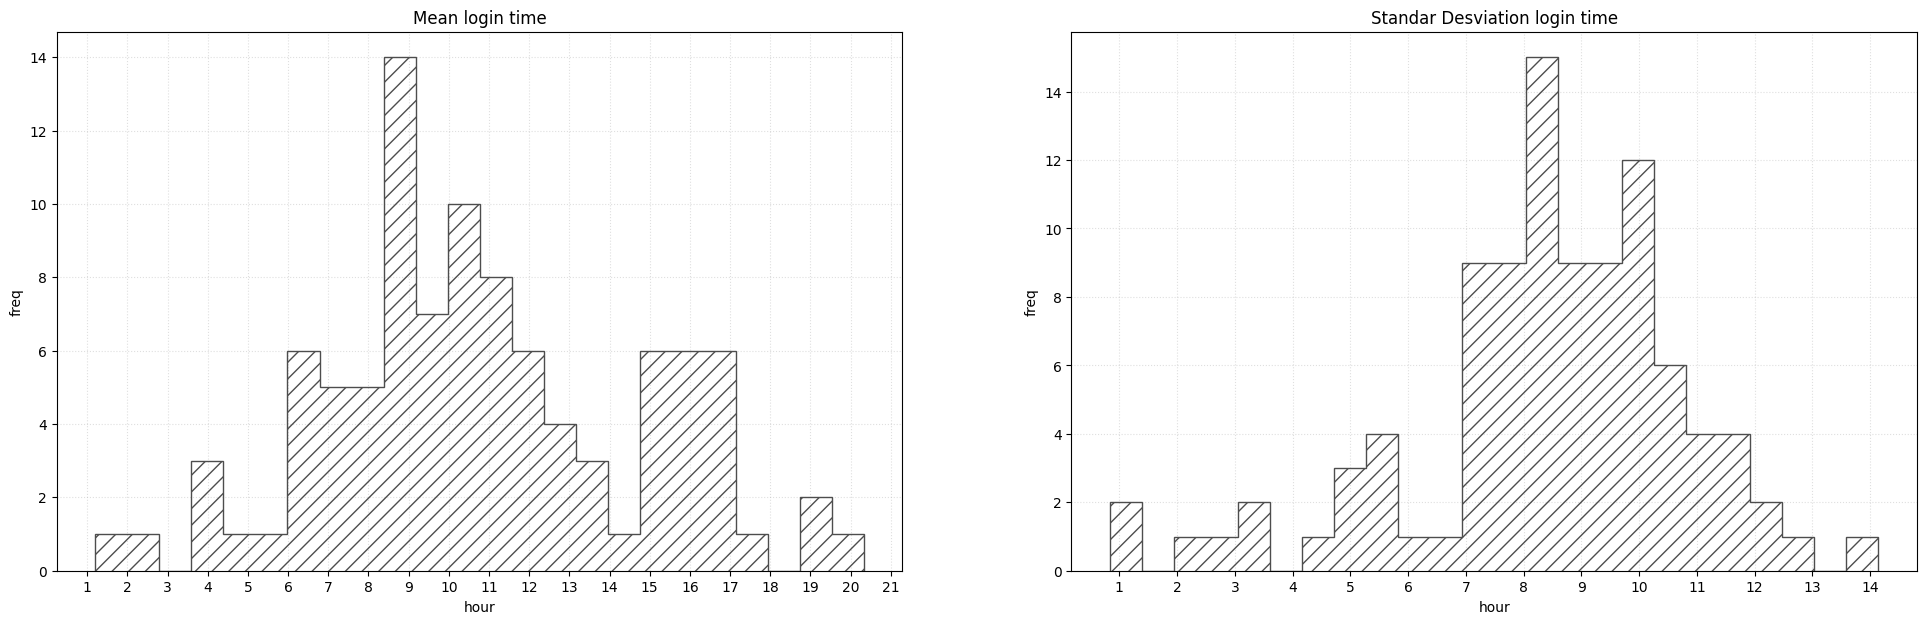

In [41]:
configs = {
    'bins':24,
    'color': '0.3',
    'histtype': 'step',
    'fill': False,
    'hatch':'//',
}

plt.figure(figsize=((12 + 12, 7)))
plt.subplot(1, 2, 1)
plt.title('Mean login time')
plt.ylabel('freq')
plt.xlabel('hour')
plt.hist(loggins_mean_std['mean'], **configs)
plt.grid(linestyle=':', alpha=.4)
plt.locator_params(axis='x', tight=True, nbins=24)
plt.subplot(1, 2, 2)
plt.title('Standar Desviation login time')
plt.ylabel('freq')
plt.xlabel('hour')
plt.hist(loggins_mean_std['std'], **configs)
plt.grid(linestyle=':', alpha=.4)
plt.locator_params(axis='x', tight=True, nbins=24)
plt.show()

Agregamos estos datos al ds facilemente co operacioones pandas:

---

# Problema 2: Respondiendo a la propuesta por el integrante de Mercado Libre:
"*Podríamos evaluar los horarios de accesos de cada usuario para determinar irregularidades de uso del sitio para dicho usuario o sacar algún estimado de “horario normal de utilización” para luego agregar esta feature binaria a nuestro dataset*"

In [42]:
loggins_mean_std = loggins_mean_std
loggins_mean_std.rename(columns={'mean': 'tipic-mean-loggin', 'std':'tipic-std-loggin'}, inplace=True)

ds = pd.merge(ds, loggins_mean_std.reset_index(), validate="many_to_one", on='user-id')

---

# Problema planteado 3:

En el grafico de la **celda 40** notamos dos cosas sumamente relevantes
1. Se nota un *doble pico* en la media de las conecciones, lo que podria indicar que puede exisitir - o no- horas anomalas de conecciones en el dataset
    * esto se puede probar verificando si existe alguna correlacion entre los usuarios que se conectan en la media del segundo pico -verificar si existe o no una correspondencia de usuarios en ambos picos-
        - si se prueba que no existe correspondencia, entonces es posible remover los datos del pico mas chico de forma segura -para considerarlos como datos normales-
2. Vemos que la desviacion estandar es sumamente amplia (14 horas) esto indica que algunos usuarios se conectan con 14 horas de diferencia respecto de su horario normal.
    * probabr si existe algun cambio de este comportamiento en el dataset si eliminamos las supuestas conecciones ***Anormales***
    
(figura complementaria que explica lo que se dice)

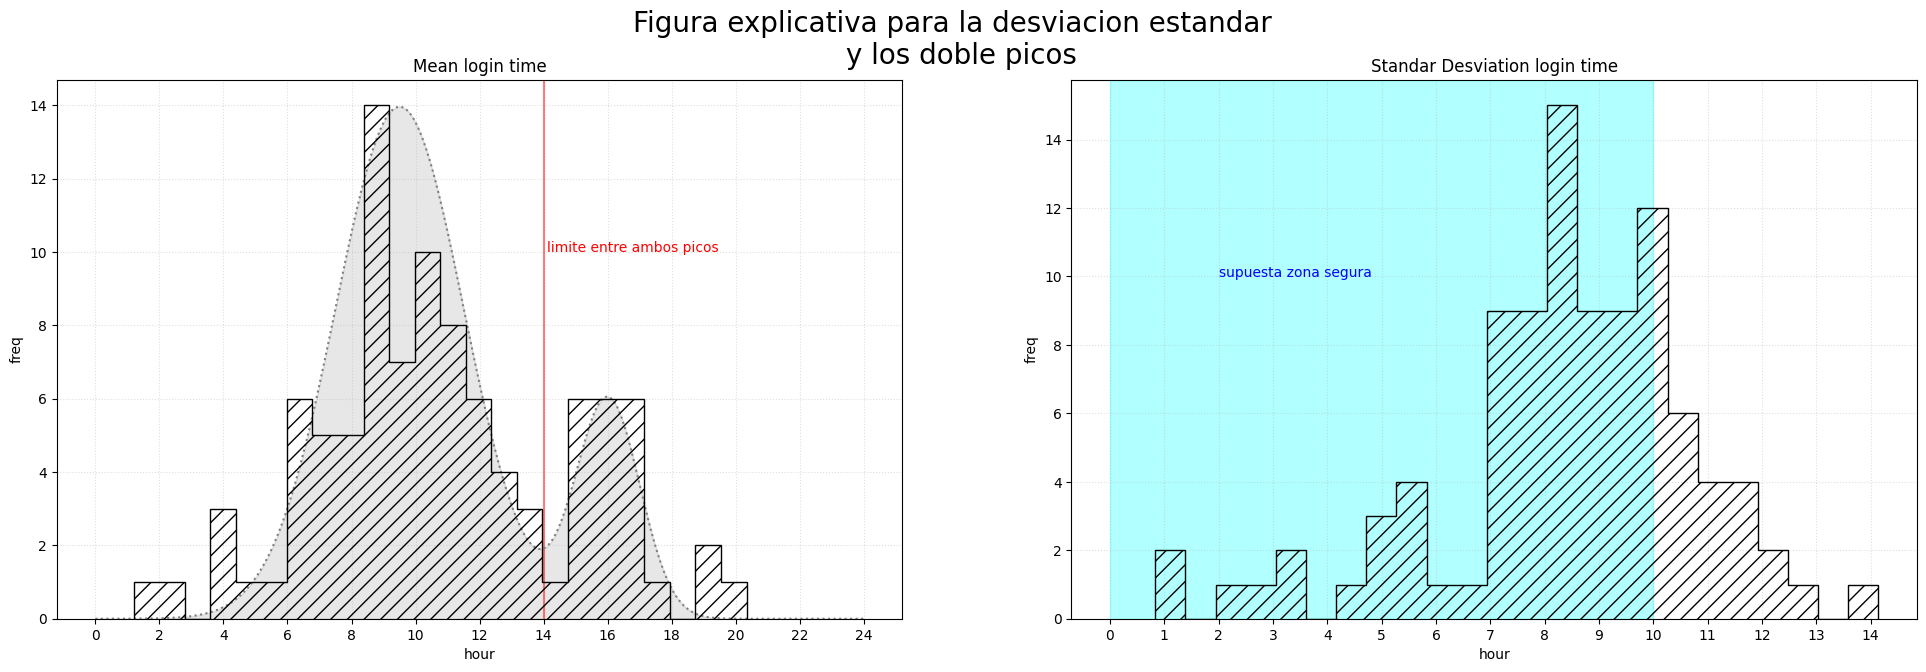

In [43]:
def plot_exp(loggins_mean_std):
    configs = {
        'bins':24,
        'color': '0',
        'histtype': 'step',
        'fill': False,
        'hatch':'//',
    }
    # mean
    plt.figure(figsize=((12 + 12, 7)))
    plt.suptitle(
        'Figura explicativa para la desviacion estandar \n y los doble picos',
        fontsize=20
    )

    plt.subplot(1, 2, 1)
    plt.title('Mean login time')
    x = np.linspace(start=0, stop=24, num=500)
    y1 = norm.pdf(x, 9.5, 2)*70
    y2 = norm.pdf(x, 16, 1)*15
    plt.text(x=14.1, y=10, s='limite entre ambos picos', color='Red')
    plt.axvline(x=14, color='Red', alpha=.5)
    plt.plot(x, (y1 + y2), color='.5', linestyle=':')
    plt.fill_between(x, y2 + y1, 0, alpha=.1, color='0.1')
    plt.ylabel('freq')
    plt.xlabel('hour')
    plt.hist(loggins_mean_std['tipic-mean-loggin'], **configs)
    plt.grid(linestyle=':', alpha=.4)
    plt.locator_params(axis='x', tight=True, nbins=24)

    # std
    plt.subplot(1, 2, 2)
    plt.title('Standar Desviation login time')
    plt.ylabel('freq')
    plt.xlabel('hour')
    plt.hist(loggins_mean_std['tipic-std-loggin'], **configs)
    plt.axvspan(0, 10, alpha=.3, color='cyan')
    plt.grid(linestyle=':', alpha=.4)
    plt.text(x=2, y=10, s='supuesta zona segura', color='Blue')
    plt.locator_params(axis='x', tight=True, nbins=24)
    plt.show()
plot_exp(loggins_mean_std)

In [44]:
limite = ds['loggin-hour'] <= 14

pico1 = ds[limite]
pico2 = ds[~limite]

In [45]:
def plot_mean_std(ds, title=''):
    loggins_mean_std = (
        ds
        [ds['loggin-hour'].notna()]
        .groupby('user-id')
        ['loggin-hour'].agg([np.mean, np.std])
    )
    configs = {
        'bins':24,
        'color': '0.3',
        'histtype': 'step',
        'fill': False,
        'hatch':'//',
    }

    plt.figure(figsize=((12 + 12, 7)))
    plt.suptitle(title, fontsize=20)
    plt.subplot(1, 2, 1)
    plt.title('Mean login time')
    plt.ylabel('freq')
    plt.xlabel('hour')
    plt.hist(loggins_mean_std['mean'], **configs)
    plt.grid(linestyle=':', alpha=.4)
    plt.locator_params(axis='x', tight=True, nbins=24)
    plt.subplot(1, 2, 2)
    plt.title('Standar Desviation login time')
    plt.ylabel('freq')
    plt.xlabel('hour')
    plt.hist(loggins_mean_std['std'], **configs)
    plt.grid(linestyle=':', alpha=.4)
    plt.locator_params(axis='x', tight=True, nbins=24)
    plt.show()

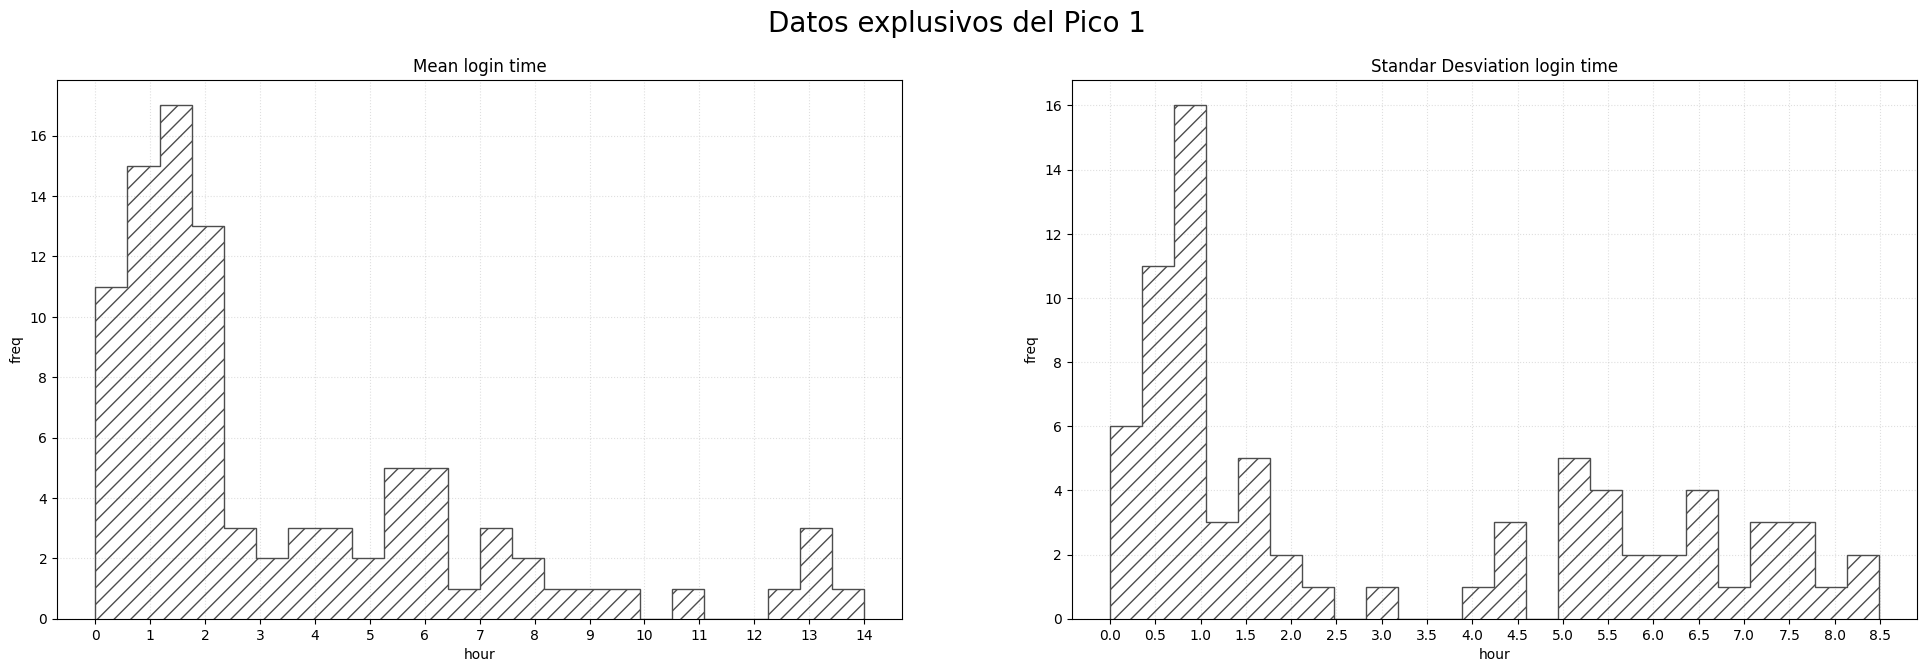

In [46]:
plot_mean_std(pico1, title='Datos explusivos del Pico 1')

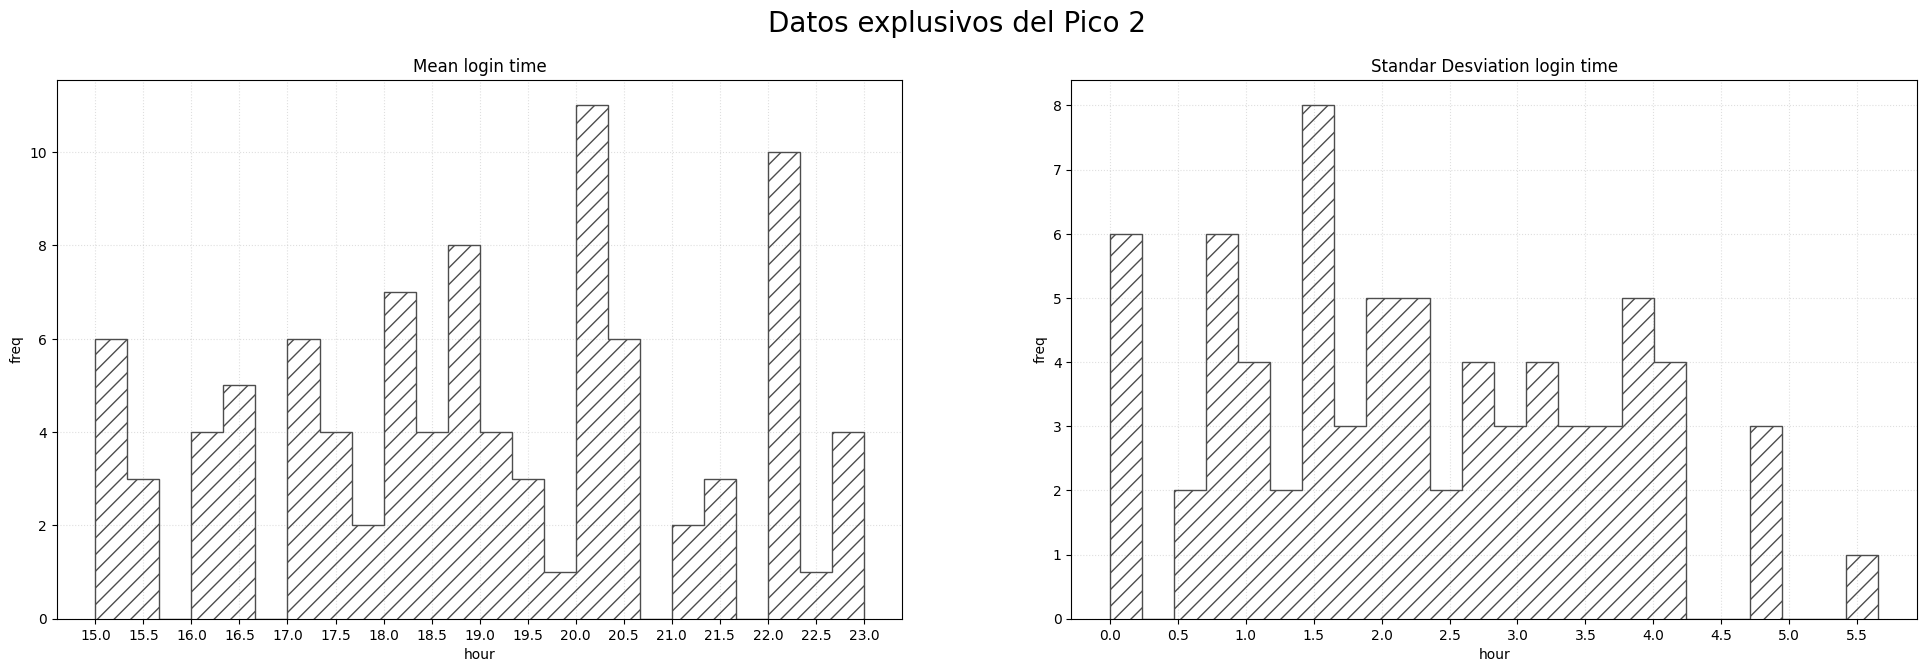

In [47]:
plot_mean_std(pico2, title='Datos explusivos del Pico 2')

Ahora queremos ver si existe alguna corralecion entre usuarios y ambos picos

In [48]:
appears = pd.concat([pico1['user-id'].value_counts(), pico2['user-id'].value_counts()], axis=1)
appears.columns = ['pico1', 'pico2']
appears

pico1  pico2
user-id              
user049   24.0   18.0
user083   10.0    4.0
user059    8.0    5.0
user135    8.0    6.0
user071    8.0    4.0
...        ...    ...
user195    1.0    2.0
user077    NaN    4.0
user129    NaN    4.0
user131    NaN    4.0
user186    NaN    3.0

[98 rows x 2 columns]

Ahora vemos en cuales picos cuantos usuarios noa parecen:

In [49]:
appears.isna().sum()

pico1    4
pico2    3
dtype: int64

Dentro de la cantidad de usuarios, estas cantidades de usuarios ausentes en cada pico son despreciables, Delatando que no hay una correlacion entre usuarios y picos, esto apoyado ademas con los histogramas de los picos nos indica que relamente los datos correspondientes al **pico 2 son casos anomalos de conecciones a deshora** delantando que en el pico 2 no hay una hora preferente de coneccion, pero si lo hay en el pico 1

In [50]:
print(
    f'La cantidad de filas del dataset del pico 1: {pico1.shape[0]}\n'
    f'La cantidad de filas del dataset del pico 2: {pico2.shape[0]}'
)

La cantidad de filas del dataset del pico 1: 318
La cantidad de filas del dataset del pico 2: 312


vemos que ambos conjuntos estan bastante bien equilibrado

In [51]:
pico1.head()

user-id  session-duration  loggin-hour  try-conect  click(Btn_Skip)   
0   user136             432.0          6.0           1                0  \
1   user136             347.0          5.0           1                0   
5   user136            1414.0          3.0           1                0   
6   user136              40.0         14.0           1                0   
10  user136              29.0          1.0           1                0   

    click(Menuopt_AllPapers)  click(Btn_Login)  click(Link_PaperInfos)   
0                          1                 1                       0  \
1                          1                 1                       0   
5                          1                 1                       0   
6                          1                 1                       0   
10                         1                 1                       0   

    click(Link_Download)  click(Btn_EndSession)  ...  Page_UploadPaper   
0                      0                      1  ...                 0  \
1                      0                      1  ...                 0   
5                      0                      1  ...                 0   
6                      0                      1  ...                 0   
10                     0                      1  ...                 0   

    Page_SubmitComment  Page_ConfigSystem  Page_EditPaper  Page_EditComment   
0                    0                  0               0                 0  \
1                    0                  0               0                 0   
5                    0                  0               0                 0   
6                    0                  0               0                 0   
10                   0                  0               0                 0   

    Page_ConfirmRemoveComment  Page_PaperInfos  Page_PostQuestion   
0                           0                0                  0  \
1                           0                0                  0   
5                           0                0                  0   
6                           0                0                  0   
10                          0                0                  0   

    tipic-mean-loggin  tipic-std-loggin  
0           14.266667           8.24159  
1           14.266667           8.24159  
5           14.266667           8.24159  
6           14.266667           8.24159  
10          14.266667           8.24159  

[5 rows x 53 columns]

### preparacion del dataset para entrenamiento de algunos modelos:

* DNN
* SVM
* RandomForestClassifier

In [52]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pico1['y'] = 0 # normal
pico2['y'] = 1 # anomalo
df = pd.concat([pico1, pico2])
df = df[df['loggin-hour'].notna()]
dfc = df.copy()
x_names =  df.columns[1:-3]
y_names =  [df.columns[-1]]

scaler = StandardScaler()
dfc[x_names[:2]] = scaler.fit_transform(df[x_names[:2]])

X = dfc[x_names]
y = dfc[y_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# DNN

In [53]:

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier([10, 10, 10])
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=[10, 10, 10])

In [54]:
clf.score(X_train, y_train)

0.9958419958419958

En este primer acercamiento hemos tenido un comportamiento esperado optimo, veamos que pasa frente a la validacion cruzada

In [55]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(clf, X, y, cv=5)
print('mean :',cvs.mean())
print('std :',cvs.std())

mean : 0.9983333333333334
std : 0.0033333333333333214


**Siendo objetivos este resultado es bastante trivial, dado que si la hora de loggin es depues de las 14 hrs el modelos evidentemente dira que es anomalo. Que pasa si descartamos la columna de hora de loggin ?**

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pico1['y'] = 0 # normal
pico2['y'] = 1 # anomalo
df = pd.concat([pico1, pico2])
df = df[df['loggin-hour'].notna()]
del df['loggin-hour']
dfc = df.copy()
x_names =  df.columns[1:-3]
y_names =  [df.columns[-1]]

scaler = StandardScaler()
dfc[x_names[:2]] = scaler.fit_transform(df[x_names[:2]])

X = dfc[x_names]
y = dfc[y_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
clf = MLPClassifier([10, 10, 10])
cvs = cross_val_score(clf, X, y, cv=5)
print('mean :',cvs.mean())
print('std :',cvs.std())

mean : 0.5199724517906336
std : 0.01475366722025588


En este caso el modelos no funciona bien, trataremos de aumentar las neuronas

In [58]:
clf = MLPClassifier([100, 100, 100, 100, 100, 100, 100, 100, 100])
cvs = cross_val_score(clf, X, y, cv=5)
print('mean :',cvs.mean())
print('std :',cvs.std())

mean : 0.5366666666666666
std : 0.041044812012346756


vemos que aumentando las neuronas exponencialmente el modelo logra mejorar algo. Es una probabilidad alta, que el modelo no tenga la capacidad de resolver el problema. Aunque la hora de loggin nos da una buena partida para determinar si contamos con una session anomala.

#### Visata rapida del comportamiento de otros modelos de clasificacion (una vista a la rapida solo para probar viavilidad)

# RandomForestClassifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000)
cvs = cross_val_score(clf, X, y, cv=5)
print('mean :',cvs.mean())
print('std :',cvs.std())

mean : 0.5197520661157025
std : 0.06262233358439433


# SVM

In [60]:
from sklearn.svm import SVC

clf = SVC()
cvs = cross_val_score(clf, X, y, cv=5)
print('mean :',cvs.mean())
print('std :',cvs.std())

mean : 0.5432369146005509
std : 0.026994026344346278


---

# Detector de anomalias basado en DNN (auto-encoder)

In [61]:
# === train ds ====
X_train = pico1.dropna().copy()
x_names =  pico1.columns[1:-3]
X_train = X_train[x_names]

y_names =  [pico1.columns[-1]]

scaler = StandardScaler()
X_train[x_names[:2]] = scaler.fit_transform(X_train[x_names[:2]])
X_train = X_train.sample(frac=1)

# ==== test ds ====
X_test = pico2.dropna(how='any').copy()
X_test = X_test[x_names]
X_test[x_names[:2]] = scaler.transform(X_test[x_names[:2]])

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 10
input_data = Input(shape=(X_train.shape[1]))

# Encoder
x = Dense(128, activation='relu')(input_data)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Técnica de vanguardia en codificación: capa de reducción de dimensionalidad
x = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)(x)
encoder_output = Dense(latent_dim, activation='relu')(x)

# Decoder
x = Dense(32, activation='relu')(encoder_output)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
decoder_output = Dense(X_train.shape[1], activation='sigmoid')(x)

# Definir el modelo del autoencoder
autoencoder = Model(input_data, decoder_output)
autoencoder.compile(optimizer='adam', loss='mse')

2023-05-09 02:06:29.612225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 02:06:29.614913: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


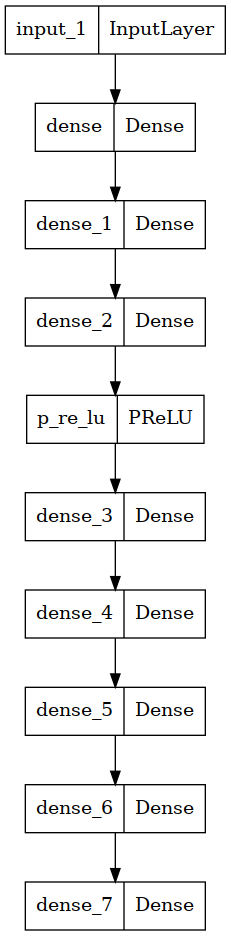

In [63]:
tf.keras.utils.plot_model(autoencoder)


In [64]:
hist = autoencoder.fit(X_train, X_train, epochs=100, verbose=0)

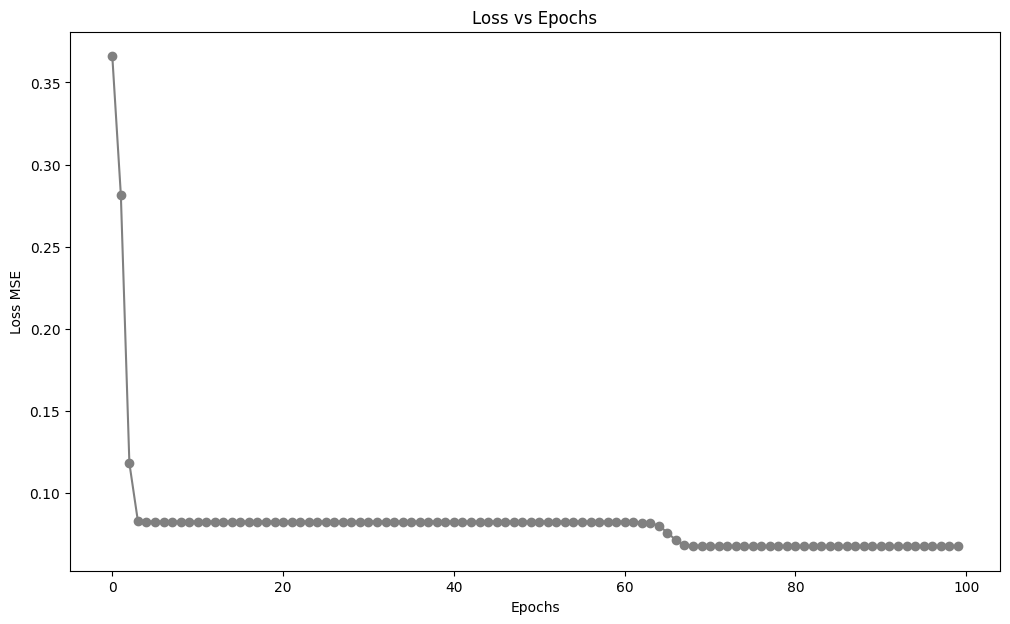

In [65]:
plt.figure(figsize=(12, 7))
plt.plot(hist.epoch, hist.history['loss'], 'o-',color='.5')
plt.xlabel('Epochs')
plt.ylabel('Loss MSE')
plt.title('Loss vs Epochs')
plt.show()


Ahora creo una funcion para determinar el score de anomalia:

In [66]:
def anomaly_score(x, model=autoencoder):
    preds = model.predict(x.values)
    return [np.abs(i -j).sum() for i, j in zip(x.values, preds)]

In [67]:
test_score = anomaly_score(X_test)
train_score = anomaly_score(X_train)

10/10 [==============================] - 0s 533us/step


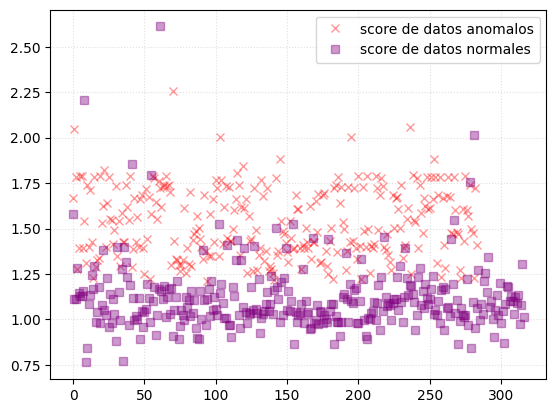

In [68]:
plt.plot(np.log(test_score), 'x', color='Red', alpha=.4, label='score de datos anomalos')
plt.plot(np.log(train_score), 's', color='Purple', alpha=.4, label='score de datos normales')
plt.legend()
plt.grid(alpha=.2, color='.4', linestyle=':')
plt.show()

Podemos establecer nosotros mismos un limite para considerar el score como "anomalo" o "normal". Arbitrariamente (y por simple analisis visual) establezco que el limite de normalidad es de 1.25:

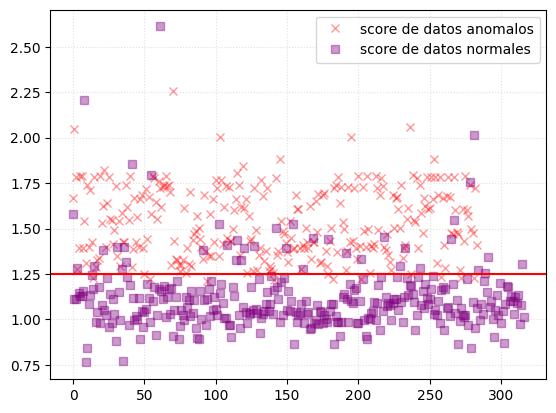

In [69]:
plt.plot(np.log(test_score), 'x', color='Red', alpha=.4, label='score de datos anomalos')
plt.plot(np.log(train_score), 's', color='Purple', alpha=.4, label='score de datos normales')
plt.legend()
plt.grid(alpha=.2, color='.4', linestyle=':')
plt.axhline(y=1.25, color='Red')
plt.show()

Podemos establecer un numero mas alto para ser mas estrictos en la categoprizacion o mas bajo si no queremos aletar todo.

### Entrenando un Suport Vector Machine para determinar la categorizacion de anomalo y normal
Otra alternativa, es que le dejemos el trabajo a un SVM para determinar cuales datos son anomalos y cuales no:

In [70]:
clf = SVC()
scores = pd.DataFrame({'X': train_score + test_score,
                       'y': [0]*len(train_score) + [1]*len(test_score)})
X_train, X_test, y_train, y_test = train_test_split(scores['X'], scores['y'], test_size=.2)
cvs = cross_val_score(clf, X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1), cv=5)
print('mean acc:',cvs.mean())
print('std acc:',cvs.std())

mean acc: 0.9104166666666668
std acc: 0.010622957319984966


Esto indica que el modelo SVM es viable para resolver el problema planteado

**PERO**: Si comparamos esta precicion con respecto a la linea que hemos demarcado, la presiccion da:

In [71]:
from sklearn.metrics import accuracy_score

def comp_score(x):
    if x >= 1.25:
        return 1
    else:
        return 0
scores['arb-pred'] = scores['X'].apply(comp_score)

In [72]:
accuracy_score(scores['y'], scores['arb-pred'])

0.47254575707154745

---

# conclusion

Hemos trabajado con un dataset que posee varias dificultades desde el punto de vista tecnico. Se ha logrado eficazmente juntar todos los datos en un unico datafarme el cual esta separado por sessiones. Con el dataframe de sessiones creaado, se ha obtenido un nuevo dataset para entrenar diversos tipos de modelos de clasificacion y regresion, entre ellos una DNN, SVM y arbol de desicion, donde **hemos creado "features nuevas"**. Tambien ha determinado que la hora de coneccion no solamente es una variable que podria ayudar a determinar "flojamente" que una coneccion es anomala, si no, que descartando dicho parametros y considerando dichas sessiones anomalas en conjunto con la cantidad y tipos de clicks en la session, hemos podido  entrenar efectivamente **un modelo de deteccion de anomalias** con apoyo de un otro modelo **SVM** logra determinar cuales sessiones son anomalas de las que hemos considerado como sesiones normales.
En particular, es destacable la implementacion de este modelo de deteccion de anomalias, ya que a priori no necesitamos data "Anomala" para entrenarlo, solo con data "Normal" es posible entrenar dicho modelo.
---
Cesar M.